NJW:
1. sim matrix -> nule na dijagonali
2. normalized l
3. " Form the matrix U = [u1 u2...uK]by stacking the eigenvectors in columns"
4. renomalizing Y da dobijem U: Yij = Uij / sqrt(suma(Uij^2))
5. K-Means


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from sklearn.cluster import KMeans
import matplotlib.colors as mcolors
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.cluster import SpectralClustering
import time

import warnings
warnings.filterwarnings("ignore")


In [2]:
class SpectralClusteringNJW:
    def __init__(self, sigma_I, sigma_X, r, max_clusters):
        self.sigma_I = sigma_I #intsnsitiy scale
        self.sigma_X = sigma_X #spatial sclae
        self.r = r # spatial cutoff


        self.max_clusters = max_clusters

    #-----------------------učitavanje slike-----------------------------
    def load_image(self, image_path):
        self.img = io.imread(image_path, as_gray=True).astype(np.float64)
        # skaliranje brigthnessa na 0-255
        self.img *= 255  
        self.img = np.clip(self.img, 0, 255)
        self.rows, self.cols = self.img.shape
        #------------------pretvaranje pixela u čvorove------------------
        self.X = np.array([(i, j) for i in range(self.rows) for j in range(self.cols)])
        self.intensities = self.img.flatten()
        self.n = self.X.shape[0]
        self.clusters = np.zeros(self.n, dtype=int) # ???
        return self
    
    """ 1.KORAK """
    #---------------------- iz rada SM formula za simm.----------------------
    def compute_similarity_matrix(self):
        W = np.zeros((self.n, self.n))  # simmilarity matrix prema brightness
        r_sq = self.r ** 2
        for i in range(self.n):
                for j in range(i + 1, self.n):
                    spatial_dist_sq = np.linalg.norm(self.X[i] - self.X[j])
                    if spatial_dist_sq < r_sq:
                        intensity_diff_sq = np.linalg.norm(self.intensities[i] - self.intensities[j]) ** 2
                        w_ij = np.exp(-intensity_diff_sq / (self.sigma_I ** 2)) * \
                            np.exp(-spatial_dist_sq**2 / (self.sigma_X ** 2))
                        W[i, j] = w_ij
                        W[j, i] = w_ij

            
        self.W = W
        return self
    
    #druga verzija similarity_matrix koja dobro clusterira
    def compute_similarity_matrix_2(self):
        h, w = self.img.shape
        coords = np.indices((h, w)).reshape(2, -1).T
        intensities = self.img.flatten().reshape(-1, 1)

        spatial_sim = rbf_kernel(coords, coords, gamma=0.001)
        intensity_sim = rbf_kernel(intensities, intensities, gamma=0.01)

        self.W = spatial_sim * intensity_sim
        return self

    """ 2.KORAK """
    #---------------------- eigenvrijednosti - eigenvektori ----------------
    def compute_laplacian(self, W=None):
        #L = D - W -> nenormalizirana matrica
        if W is None:
            W = self.W
        D = np.diag(np.sum(W, axis=1))
        D_inv_sqrt = np.diag([1.0 / np.sqrt(d) if d != 0 else 0 for d in np.diag(D)]) # D^1/2
        return D_inv_sqrt @ (D - W) @ D_inv_sqrt
    

    def compute_k_eigenvectors(self):
        L= self.compute_laplacian(self.W)
        # TODO: zamijeniti built-in .eigh funkciju ??
        eigvals, eigvecs = np.linalg.eigh(L)
        """ 3/4.KORAK """
        # -------------------------- top k eigenvektora ---------------------------------
        X = eigvecs[:, :self.max_clusters]
        # norm
        # TODO: maknuti.norm?
        Y = X / np.linalg.norm(X, axis=1, keepdims=True)
        
        return Y


    # pipline koji poziva sve bitne funkcije
    def segment_image(self):
        self.compute_similarity_matrix()
        """ 5.KORAK """
        Z = self.compute_k_eigenvectors()
        kmeans = KMeans(n_clusters=self.max_clusters)
        labels = kmeans.fit_predict(Z)
        self.clusters = labels
        return self.clusters.reshape((self.rows, self.cols))
    
    
    #---------------------------------- average color ---------------------------------------
    def average_color(self):
        self.segmented_img = self.clusters.reshape((self.rows, self.cols))

        group_sums = np.zeros(self.max_clusters)
        group_counts = np.zeros(self.max_clusters)

        for i in range(self.segmented_img.shape[0]):
            for j in range(self.segmented_img.shape[1]):
                group_label = self.segmented_img[i, j]
                group_value = self.img[i, j]
                
                group_sums[group_label] += group_value
                group_counts[group_label] += 1

        group_averages = (group_sums / group_counts) / 255
        rgb_grouped = [(group_averages[i], group_averages[i], group_averages[i]) for i in range(0, len(group_averages))]
        cmap = mcolors.ListedColormap(rgb_grouped)
    
        return cmap

        

    def visualize(self):
        self.segmented_img = self.clusters.reshape((self.rows, self.cols))
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))
        cmap_custom = self.average_color()
        axs[0].imshow(self.img, cmap='gray')
        axs[0].set_title('Original')
        axs[0].axis('off')
        axs[1].imshow(self.segmented_img, cmap=cmap_custom)
        axs[1].set_title('Spectralno Grupiranje NJW')
        axs[1].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        
        

In [3]:
""" clusterer = SpectralClusteringNJW(sigma_I=50, sigma_X=100, r=20, max_clusters =4)
clusterer.load_image('eagle_30px.png')
segmented = clusterer.segment_image()
clusterer.visualize() """

" clusterer = SpectralClusteringNJW(sigma_I=50, sigma_X=100, r=20, max_clusters =4)\nclusterer.load_image('eagle_30px.png')\nsegmented = clusterer.segment_image()\nclusterer.visualize() "

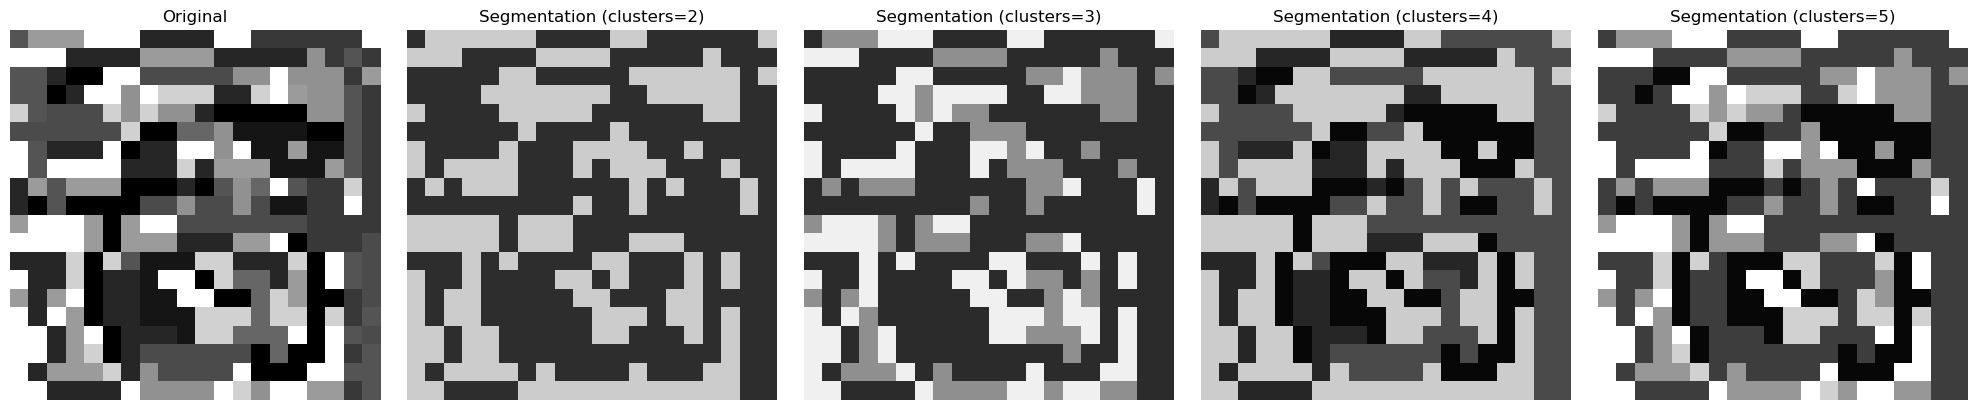

In [4]:
# različiti max_clusters
max_clusters_values = [2,3,4,5]  
fig, axs = plt.subplots(1, len(max_clusters_values) + 1, figsize=(20, 4))
clusterer = SpectralClusteringNJW(sigma_I=0.1, sigma_X=5.0, r=10, max_clusters =1)
clusterer.load_image('images/image3.png') 

axs[0].imshow(clusterer.img, cmap='gray')
axs[0].set_title('Original')
axs[0].axis('off')

for idx, m in enumerate(max_clusters_values):
        clusterer = SpectralClusteringNJW(sigma_I=50, sigma_X=100, r=20, max_clusters =m)
        clusterer.load_image('images/image3.png')
        segmented = clusterer.segment_image()
        # ------------------------------------------------------  custom set boja ----------------------------
        cmap_custom = clusterer.average_color()
        axs[idx+1].imshow(segmented, cmap=cmap_custom)
        axs[idx+1].set_title(f'Segmentation (clusters={m})')
        axs[idx+1].axis('off')

plt.tight_layout()
plt.show()

In [5]:
def visualize_line(image_name, values, custom):
    fig, axs = plt.subplots(1, len(values) + 1, figsize=(20, 4))

    clusterer = SpectralClusteringNJW(sigma_I=0.1, sigma_X=5.0, r=10, max_clusters =1)
    clusterer.load_image(image_name) 

    axs[0].imshow(clusterer.img, cmap='gray')
    axs[0].set_title('Original')
    axs[0].axis('off')

    for idx, m in enumerate(values):
        clusterer = SpectralClusteringNJW(sigma_I=50, sigma_X=100, r=20, max_clusters =m)
        clusterer.load_image(image_name)
        segmented = clusterer.segment_image()
        # ------------------------------------------------------  custom set boja ----------------------------
        if custom:
            cmap_custom = clusterer.average_color()
            axs[idx + 1].imshow(segmented, cmap=cmap_custom)
        else:
            axs[idx + 1].imshow(segmented, cmap='gray')
        axs[idx + 1].set_title(f'Segmentation (max_cluster={m})')
        axs[idx + 1].axis('off')

    plt.tight_layout()
    plt.show()

custom boje


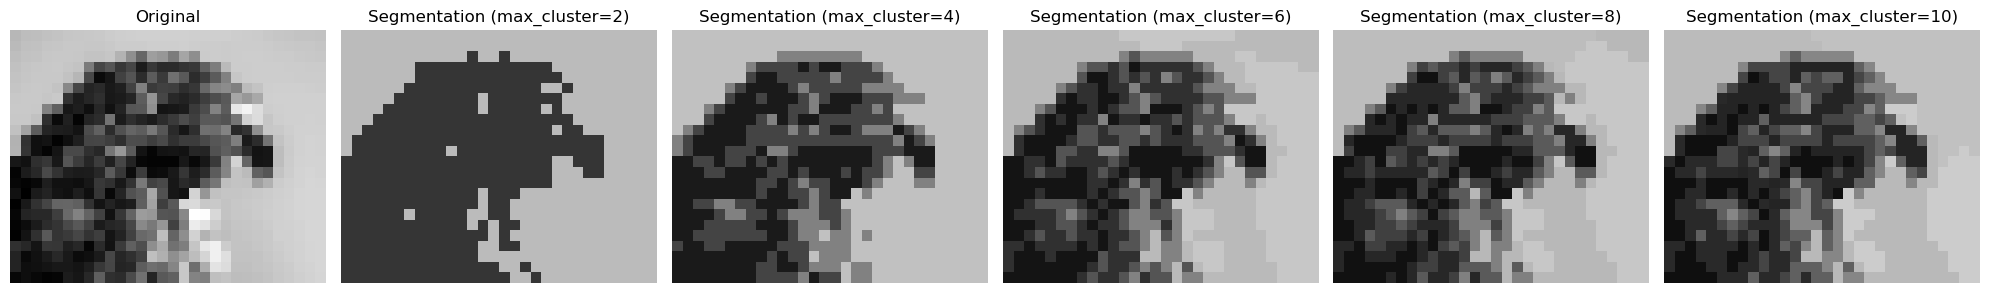

random boje


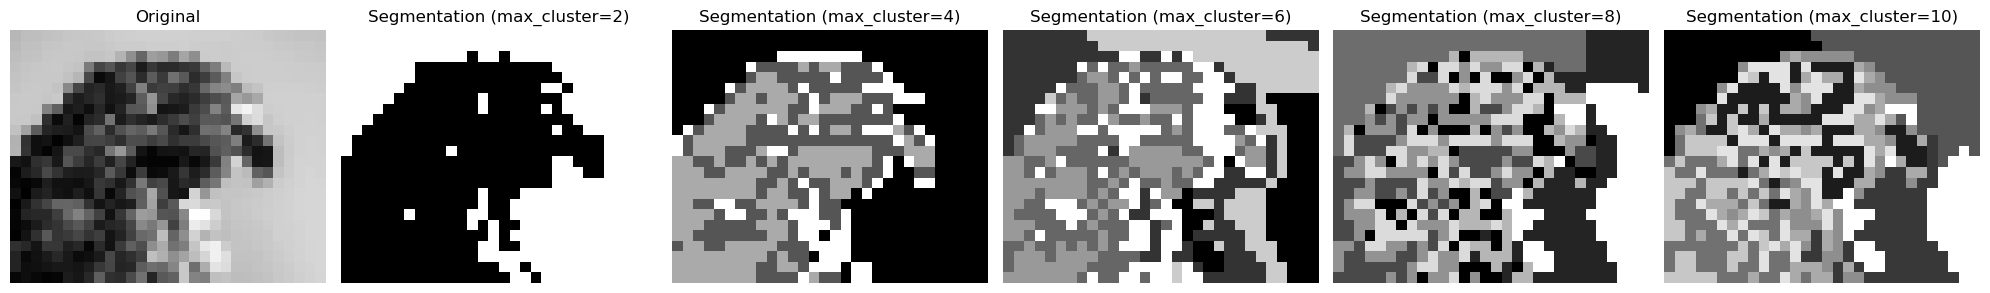

In [6]:
print('custom boje')
visualize_line('images/eagle_30px.png', [2,4,6,8,10], True)
print('random boje')
visualize_line('images/eagle_30px.png', [2,4,6,8,10], False)

komentar: rezultati su dobri do 4 clustera, dalje se gubi - pozadina?? (built-in metoda ne daje rezultate dalje od 4 clustera na tom primjeru)
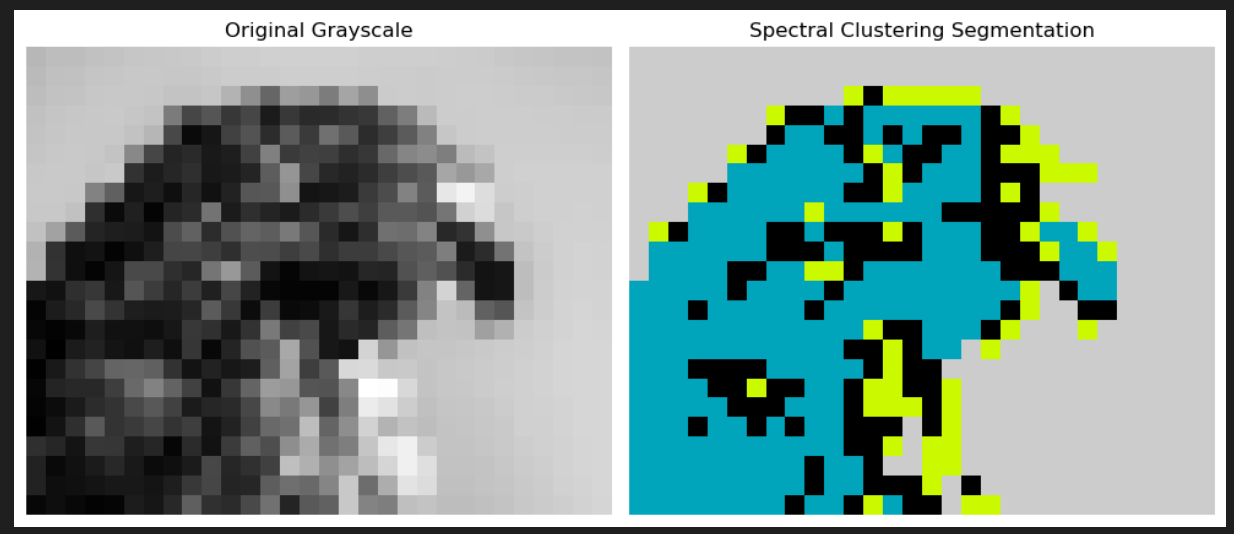

custom boje:


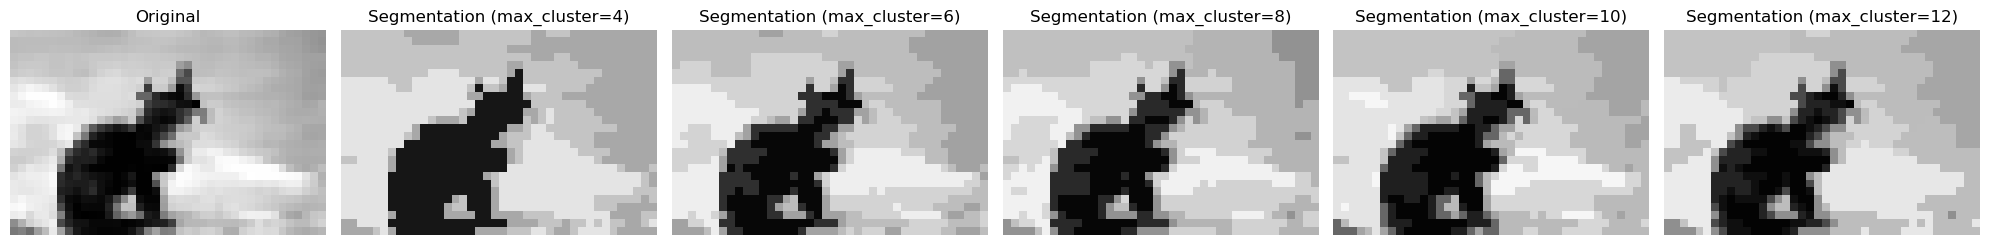

random boje:


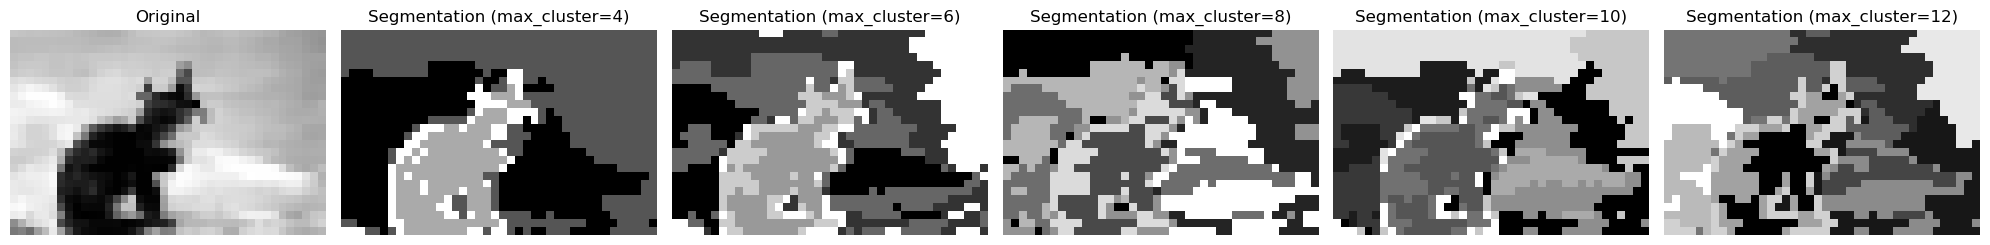

In [8]:
print('custom boje:')
visualize_line('images/cat_40px.png', [4,6,8,10,12], True)
print('random boje:')
visualize_line('images/cat_40px.png', [4,6,8,10,12], False)

custom boje


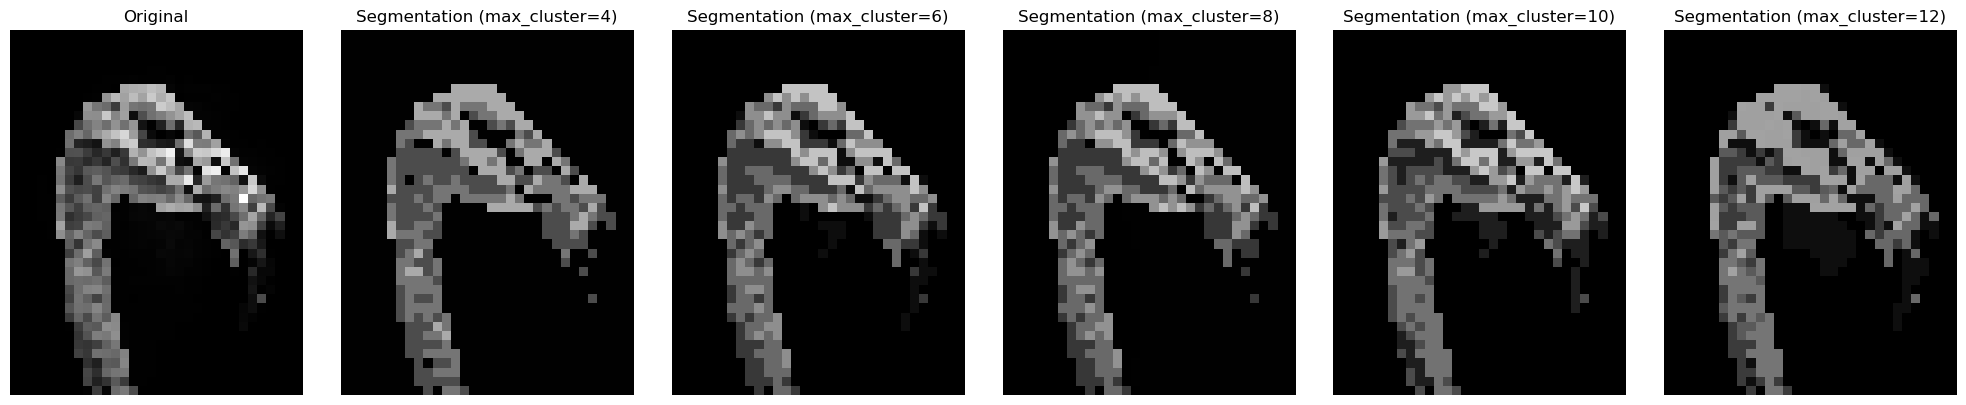

random boje


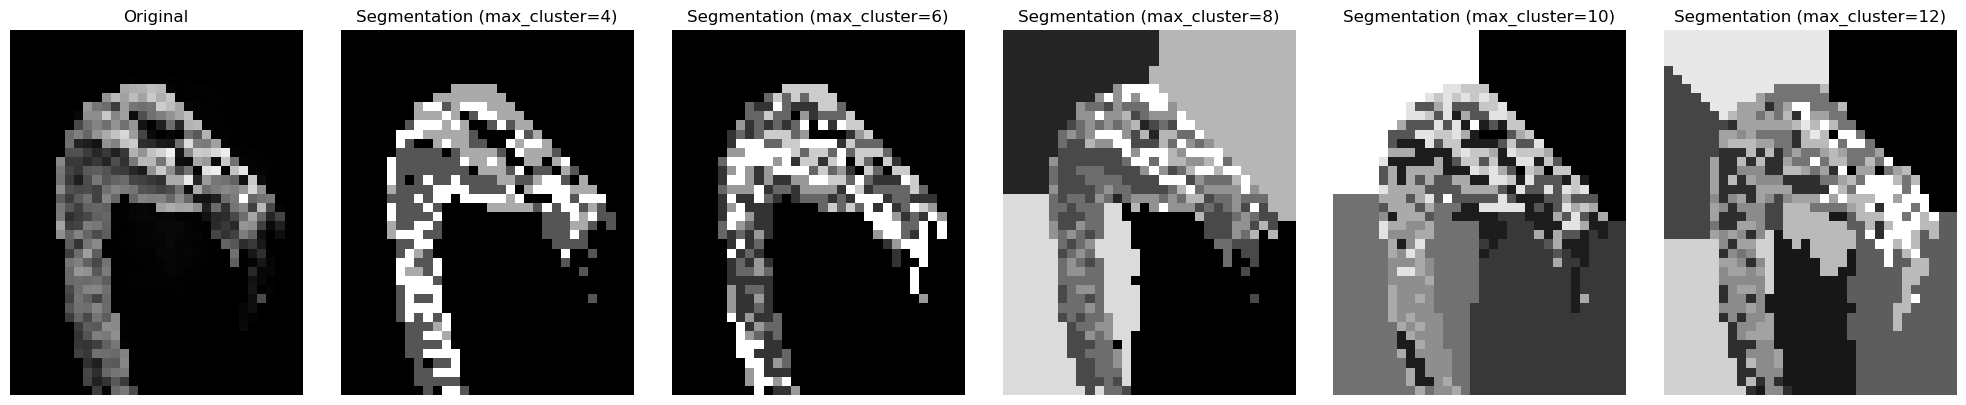

In [ ]:
print('custom boje')
visualize_line('images/bird_40px.png', [4,6,8,10,12], True)
print('random boje')
visualize_line('images/bird_40px.png', [4,6,8,10,12], False)